In [1]:
!pip -q install xarray-spatial skops shap git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample
# Make sure git install worked
import xbatcher
print(xbatcher.__version__)

0.1.dev236+g2e721fc


In [2]:
import xarray as xr
import xrspatial
import rioxarray
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import shap
import os
import skops.io as sio

try:
    import util
except ImportError:
    if 'notebooks' in os.getcwd():
        os.chdir("..")
finally:
    import util

/home/jovyan/ForestLST/util/__init__.py:13: UserWarning: ImportError on util.training: No module named 'torch'. Module util.training will not be loaded.
  warnings.warn(f"ImportError on util.training: {str(e)}. Module util.training will not be loaded.")


Prepare data. Here we are trying to replicate the RF described in [Preisler et al. (2017)](https://www.sciencedirect.com/science/article/pii/S0378112717304772) so we need to do some feature engineering to match their work.

In [3]:
ds = xr.load_dataset("mort_datasets/westmort.nc")
ds = ds.where(ds["treecover"] >= 10)
ds

<xarray.Dataset> Size: 4GB
Dimensions:      (y: 2608, x: 2360, time: 27)
Coordinates:
  * x            (x) float64 19kB -1.39e+07 -1.389e+07 ... -1.154e+07 -1.154e+07
  * y            (y) float64 21kB 6.28e+06 6.279e+06 ... 3.674e+06 3.673e+06
  * time         (time) int64 216B 1997 1998 1999 2000 ... 2020 2021 2022 2023
Data variables: (12/17)
    elev         (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    slope        (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    northness    (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    eastness     (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    fire         (time, y, x) float32 665MB nan nan nan nan ... nan nan nan nan
    prcp         (time, y, x) float32 665MB nan nan nan nan ... nan nan nan nan
    ...           ...
    pinus        (y, x) float64 49MB nan nan nan nan nan ... nan nan nan nan nan
    populus      (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    pseudotsuga  (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    tsuga        (y, x) float32 25MB nan nan nan nan nan ... nan nan nan nan nan
    gfw_damage   (time, y, x) float32 665MB nan nan nan nan ... nan nan nan nan
    spatial_ref  (y, x) float64 49MB nan nan nan nan nan ... nan nan nan nan nan

In [4]:
kernel = np.array([
    [1, 1, 1],
    [1, 0, 1],
    [1, 1, 1]
])

def focal_max(arr):
    arr = arr.isel(time=0)
    return xrspatial.focal.focal_stats(arr, kernel, stats_funcs=["max"]).isel(stats=0, drop=True)

def make_autocor_covariates(ds, target):
    rhost1 = (ds["treecover"] - ds[target]).clip(0, 100).shift(time=1).rename("rhost1")
    # xrspatial only convolves on 2D arrays so we have to do this
    # groupby trick.
    near1  = ds[target].groupby("time").apply(focal_max).shift(time=1).rename("near1")
    mort1  = ds[target].shift(time=1).rename("mort1")
    return rhost1, near1, mort1

# Make these for both ADS and GFW so we can fit all the models in one shot
ds["rhost1"], ds["near1"], ds["mort1"] = make_autocor_covariates(ds, "mortality")
ds["gfw_rhost1"], ds["gfw_near1"], ds["gfw_mort1"] = make_autocor_covariates(ds, "gfw_damage")

36-year average precipitation. They based this off of the PRISM dataset but I think we can take a long-term average and just call it good.

In [5]:
ds["prcp_avg"] = ds.prcp.mean(dim="time")

fire: "Area affected by fire 2–4 yr prior"

In [6]:
ds["fire_roll_sum"] = ds.fire.rolling(time=3).sum()

There's a lot of shifting variables here to create the lagged covariates described in the paper. By convention *we will not modify coordinates of the prediction target*. Only the covariates get shifted. Note that shifts are positive because we are moving data from the past to match the position of the mortality label.

In [7]:
ds["prcp1"]  = ds["prcp"].shift(time=1)
ds["tmin1"]  = ds["tmin"].shift(time=1)
ds["fire24"] = ds["fire_roll_sum"].shift(time=2)

Now we split the dataset into training and validation and do windowing just as we did with the Unet. This is so we can be sure that differences in model performance cannot be attributed to slight differences in training data.

In [10]:
def patch_filter(ds, batch, prop_valid=0.70):
    # Accept patch if the last time doesn't have too many NaNs.
    nan_mask = ds.isel(**batch).isel(time=-1).isnull().astype(np.float32)
    
    return 1 - nan_mask.mean() >= prop_valid

def pointwise_select_with_mask(da, mask):
    '''
    Select elements from ``da`` on a new dimension, defined by positive
    values in ``mask``.
    '''
    indices = np.argwhere(mask.data)
    selectors = {
        dim:xr.DataArray(indices[:, i], dims="sample")
        for i, dim in enumerate(mask.dims)
    }
    return da.isel(**selectors)

def get_batchgen_mask(ds, target, input_dims, input_overlap, filter_fn=None):
    '''
    Return binary array indicating cells selected by a batch generator.
    '''
    bgen = xbatcher.BatchGenerator(
        ds[target],
        input_dims=input_dims,
        input_overlap=input_overlap,
        filter_fn=filter_fn
    )

    mask = xr.full_like(ds[target], 0)

    for _, slices in bgen._batch_selectors.selectors.items():
        slices = tuple(slices[0][d] for d in ds[target].dims)
        mask.values[slices] = 1

    return mask

def impute_median(x):
    return x.fillna(x.median())

def dataset_to_dataframe(ds, target, bgen_dims, bgen_overlap, bgen_filter, vars_to_keep):
    assert target == vars_to_keep[0]
    ds = ds[vars_to_keep]
    mask = get_batchgen_mask(ds, target, bgen_dims, bgen_overlap, bgen_filter)
    df = pointwise_select_with_mask(ds, mask).to_dataframe()
    # Drop NaNs for target, then impute median for the rest
    df = df[~df[target].isna()]
    df = df.apply(impute_median, axis=0)
    return df

ds_train = ds.sel(time=slice(2001, 2015))
ds_valid = ds.sel(time=slice(2015, None))

unet_dims = dict(x=64, y=64, time=5)
unet_overlap = dict(x=0, y=0, time=4)

common_vars = ["fire24", "tmin1", "prcp1", "prcp_avg"]
ads_vars = ["mortality", "near1", "rhost1", "mort1"]
gfw_vars = ["gfw_damage", "gfw_near1", "gfw_rhost1", "gfw_mort1"]

df_train_ads = dataset_to_dataframe(ds_train, "mortality" , unet_dims, unet_overlap, patch_filter, ads_vars+common_vars)
df_valid_ads = dataset_to_dataframe(ds_valid, "mortality" , unet_dims, unet_overlap, patch_filter, ads_vars+common_vars)
df_train_gfw = dataset_to_dataframe(ds_train, "gfw_damage", unet_dims, unet_overlap, patch_filter, gfw_vars+common_vars)
df_valid_gfw = dataset_to_dataframe(ds_valid, "gfw_damage", unet_dims, unet_overlap, patch_filter, gfw_vars+common_vars)

In [11]:
print(df_train_ads.shape)
print(df_train_gfw.shape)

(6094499, 11)
(9165120, 11)


Model training. As the above shapes indicate, there's a looooooot of data here. Start by making a learning curve to determine how much data we need.

In [23]:
def split_xy(df, target):
    return (
        df.reset_index(drop=True).drop(columns=[target] + ["x", "y", "time"]).to_numpy(),
        df.reset_index(drop=True)[target].to_numpy()
    )
    
X_train, y_train = split_xy(df_train_ads, "mortality")

[learning_curve] Training set sizes: [ 30472  60944  91417 121889 152362 182834 213307 243779 274252 304724]
[CV] END .................................................... total time=   5.8s
[CV] END .................................................... total time=   8.4s
[CV] END .................................................... total time=  11.3s
[CV] END .................................................... total time=  12.5s
[CV] END .................................................... total time=  14.7s
[CV] END .................................................... total time=  16.8s
[CV] END .................................................... total time=  19.7s
[CV] END .................................................... total time=  22.2s
[CV] END .................................................... total time=  24.4s
[CV] END .................................................... total time=  25.3s
[CV] END .................................................... total time=   6.7s


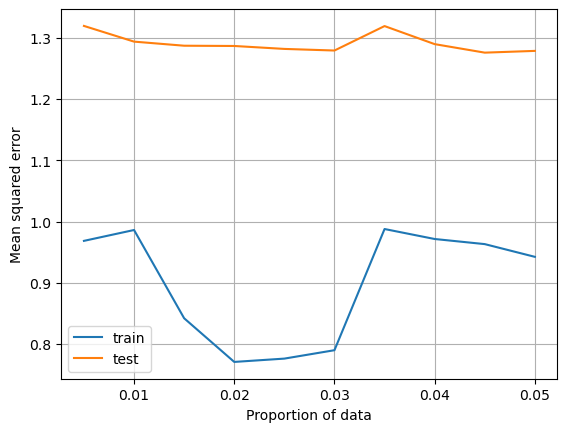

In [25]:
from sklearn.model_selection import learning_curve

sizes, train_scores, test_scores = learning_curve(
    RandomForestRegressor(max_features="sqrt", min_samples_leaf=1000),
    X_train, y_train,
    scoring="neg_mean_squared_error",
    verbose=2,
    cv=2,
    train_sizes=np.linspace(0.01, 0.1, num=10)
)
plt.plot(sizes/X_train.shape[0], -train_scores.mean(axis=1), label="train")
plt.plot(sizes/X_train.shape[0], -test_scores.mean(axis=1) , label="test")
plt.grid()
plt.ylabel("Mean squared error")
plt.xlabel("Proportion of data")
plt.legend()
plt.show()

Performance seems to stabilize pretty quickly with just a small handful of the data.

Fit four models, [GFW, ADS] x [Autocorrelation, No Autocorrelation]

In [26]:
downsample_step = 10

ads_train_x, ads_train_y = split_xy(df_train_ads[::downsample_step], "mortality")
ads_valid_x, ads_valid_y = split_xy(df_valid_ads, "mortality")

gfw_train_x, gfw_train_y = split_xy(df_train_gfw[::downsample_step], "gfw_damage")
gfw_valid_x, gfw_valid_y = split_xy(df_valid_gfw, "gfw_damage")

rf_ads = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=1000, random_state=20250714)
rf_gfw = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=1000, random_state=20250714)

In [47]:
def get_results(y, y_hat):
    mse = mean_squared_error(y_hat, y)
    nrmse = mse / np.std(y)
    r = np.corrcoef(y, y_hat)[0, 1]
    return {
        "mse": mse,
        "nrmse": nrmse,
        "r": r
    }

rf_ads.fit(ads_train_x, ads_train_y)
rf_gfw.fit(gfw_train_x, gfw_train_y)

# Training performance
print("Training")
print("ADS:", get_results(ads_train_y, rf_ads.oob_prediction_))
print("GFW:", get_results(gfw_train_y, rf_gfw.oob_prediction_))

# Run validation predictions
y_hat_ads = rf_ads.predict(ads_valid_x)
y_hat_gfw = rf_gfw.predict(gfw_valid_x)

# Validation performance - save these for figures
rf_ads_valid = get_results(ads_valid_y, y_hat_ads)
rf_gfw_valid = get_results(gfw_valid_y, y_hat_gfw)

print("Validation")
print("ADS:", rf_ads_valid)
print("GFW:", rf_gfw_valid)

Training
ADS: {'mse': 1.1756417109610842, 'nrmse': 1.012071429325166, 'r': 0.3616046959318444}
GFW: {'mse': 9.246887247818648, 'nrmse': 2.9987461367603494, 'r': 0.1668603084933586}
Validation
ADS: {'mse': 5.913168033857063, 'nrmse': 2.3617895418693875, 'r': 0.2861077252863821}
GFW: {'mse': 8.79242709428448, 'nrmse': 2.9197834824797115, 'r': 0.17688837786778913}


Now do a second run without the autocor variables.

In [46]:
ads_train_noac_x = ads_train_x[:, -4:]
ads_valid_noac_x = ads_valid_x[:, -4:]
gfw_train_noac_x = gfw_train_x[:, -4:]
gfw_valid_noac_x = gfw_valid_x[:, -4:]

rf_ads_noac = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=1000, random_state=20250714)
rf_gfw_noac = RandomForestRegressor(oob_score=True, max_features="sqrt", min_samples_leaf=1000, random_state=20250714)

rf_ads_noac.fit(ads_train_noac_x, ads_train_y)
rf_gfw_noac.fit(gfw_train_noac_x, gfw_train_y)

# Training performance
print("Training")
print("ADS:", get_results(ads_train_y, rf_ads_noac.oob_prediction_))
print("GFW:", get_results(gfw_train_y, rf_gfw_noac.oob_prediction_))

# Run validation predictions
y_hat_ads_noac = rf_ads_noac.predict(ads_valid_noac_x)
y_hat_gfw_noac = rf_gfw_noac.predict(gfw_valid_noac_x)

# Validation performance - save these for figures
rf_ads_noac_valid = get_results(ads_valid_y, y_hat_ads)
rf_gfw_noac_valid = get_results(gfw_valid_y, y_hat_gfw)

print("Validation")
print("ADS:", rf_ads_noac_valid)
print("GFW:", rf_gfw_noac_valid)

Training
ADS: {'mse': 1.2914541825799168, 'nrmse': 1.1117705915717426, 'r': 0.20807372116241307}
GFW: {'mse': 9.443281502242291, 'nrmse': 3.0624363814828377, 'r': 0.08281614096712821}
Validation
ADS: {'mse': 6.300039937425069, 'nrmse': 2.5163107749306475, 'r': 0.04625523602077747}
GFW: {'mse': 9.047065817776678, 'nrmse': 3.0043437444960484, 'r': 0.05624059736037698}


Naive model performance - last observation and long-term average. Only do this for the validation set.

In [32]:
# Last obs is just in the data frames so we can use that
ads_lastobs = get_results(df_valid_ads["mortality"], df_valid_ads["mort1"])
gfw_lastobs = get_results(df_valid_gfw["gfw_damage"], df_valid_gfw["gfw_mort1"])

print("Last obs")
print("ADS:", ads_lastobs)
print("GFW:", gfw_lastobs)

Last obs
ADS: {'mse': 8.023882865905762, 'nrmse': 3.204833809009084, 'r': 0.2592178114835709}
GFW: {'mse': 17.1025333404541, 'nrmse': 5.679394573504396, 'r': 0.10507895383822768}


In [45]:
# Long-term spatial average we have to join on coordinates
ads_spatavg = ds_train["mortality"].mean(dim="time").rename("ads_spatavg")\
    .to_dataframe().dropna()
gfw_spatavg = ds_train["gfw_damage"].mean(dim="time").rename("gfw_spatavg")\
    .to_dataframe().dropna()

ads_valid_join = df_valid_ads.set_index(["y", "x"]).join(ads_spatavg, on=["y", "x"], how="inner")
gfw_valid_join = df_valid_gfw.set_index(["y", "x"]).join(gfw_spatavg, on=["y", "x"], how="inner")

ads_spatavg_result = get_results(ads_valid_join["mortality"], ads_valid_join["ads_spatavg"])
gfw_spatavg_result = get_results(gfw_valid_join["gfw_damage"], gfw_valid_join["gfw_spatavg"])

print("Spat avg")
print("ADS:", ads_spatavg_result)
print("GFW:", gfw_spatavg_result)

Spat avg
ADS: {'mse': 6.768648624420166, 'nrmse': 2.5866425208297477, 'r': 0.1486851788368348}
GFW: {'mse': 9.588812828063965, 'nrmse': 3.1842447231627413, 'r': 0.06985222989435229}


Make predictions on 2023 for the figure. Do this for both GFW and ADS, even though we may only have room for ADS in the paper.

In [49]:
df_valid_ads["rf_predict"] = y_hat_ads
df_valid_ads["rf_noac_predict"] = y_hat_ads_noac
df_valid_gfw["rf_predict"] = y_hat_gfw
df_valid_gfw["rf_noac_predict"] = y_hat_gfw_noac

df_valid_ads[df_valid_ads.time == 2023].to_csv("data_out/westmort_ads_2023.csv")
df_valid_gfw[df_valid_gfw.time == 2023].to_csv("data_out/westmort_gfw_2023.csv")

Save out models and results

In [53]:
import json

def save_dict(file, d):
    with open(file, "w+") as f:
        json.dump(d, f)

# RF objects
sio.dump(rf_ads, "data_out/west_rf_ads.skops")
sio.dump(rf_ads_noac, "data_out/west_rf_noac_ads.skops")
sio.dump(rf_gfw, "data_out/west_rf_gfw.skops")
sio.dump(rf_gfw_noac, "data_out/west_rf_noac_gfw.skops")

# RF performance
save_dict("data_out/west_ads_rf_valid.json", rf_ads_valid)
save_dict("data_out/west_gfw_rf_valid.json", rf_gfw_valid)
save_dict("data_out/west_ads_rf_noac_valid.json", rf_ads_noac_valid)
save_dict("data_out/west_gfw_rf_noac_valid.json", rf_gfw_noac_valid)

# Naive models
save_dict("data_out/west_ads_last_obs.json", ads_lastobs)
save_dict("data_out/west_gfw_last_obs.json", gfw_lastobs)
save_dict("data_out/west_ads_spat_avg.json", ads_spatavg_result)
save_dict("data_out/west_gfw_spat_avg.json", gfw_spatavg_result)

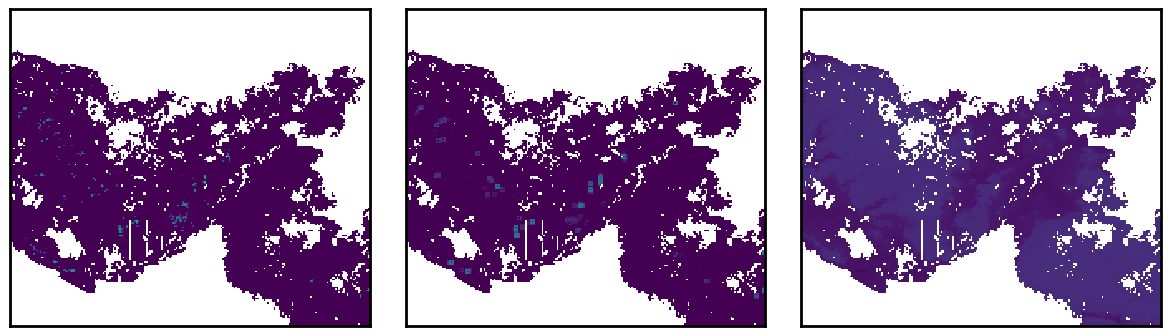

In [80]:
import geopandas as gpd
from matplotlib import colors
from matplotlib.cm import ScalarMappable
regions = gpd.read_file("data_working/figure_overlays.shp")

def make_clipped_plot(geom, **kwargs):
    p = ds23.rio.clip_box(*geom.bounds).plot(
        col="variable", 
        norm=colors.LogNorm(vmin=1e-2, vmax=1), 
        cbar_kwargs=dict(label="Proportion of cell with mortality"),
        xticks=[],
        yticks=[],
        add_labels=False,
        **kwargs
    )
    
    for ax in p.axs.flat:
        ax.set_xlabel("")
        ax.set_ylabel("")
        ax.set_title("")

    return p
    
with plt.rc_context({"font.size":24, "axes.linewidth": 2.0, "grid.linewidth": 2.0}):
    p_top = make_clipped_plot(regions.geometry[2], add_colorbar=False, figsize=(13, 5))